# Supernova distances and redshifts (pt2)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [1]:
from astroML.datasets import generate_mu_z
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import LinearRegression
from astroML.linear_model import NadarayaWatson
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

from scipy.optimize import fmin_cobyla
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import uniform, norm

import emcee
import dynesty
from dynesty.utils import resample_equal
import scipy
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
import corner
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'

/opt/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# re-fetch data

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
matrix_val = np.array((z_sample, mu_sample))
dataset_ = matrix_val.transpose()
dataset_corr_ = dataset_[dataset_[:, 0].argsort()]

---

# Gaussian Process Regression

I varied some of the kernels to see the changes:

In [3]:
kernel_s = [(kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))), (kernels.RBF(10, (1e-1, 1e1))), (kernels.ConstantKernel(1.0, (1e-3, 1e3))), kernels.DotProduct() + kernels.WhiteKernel()]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


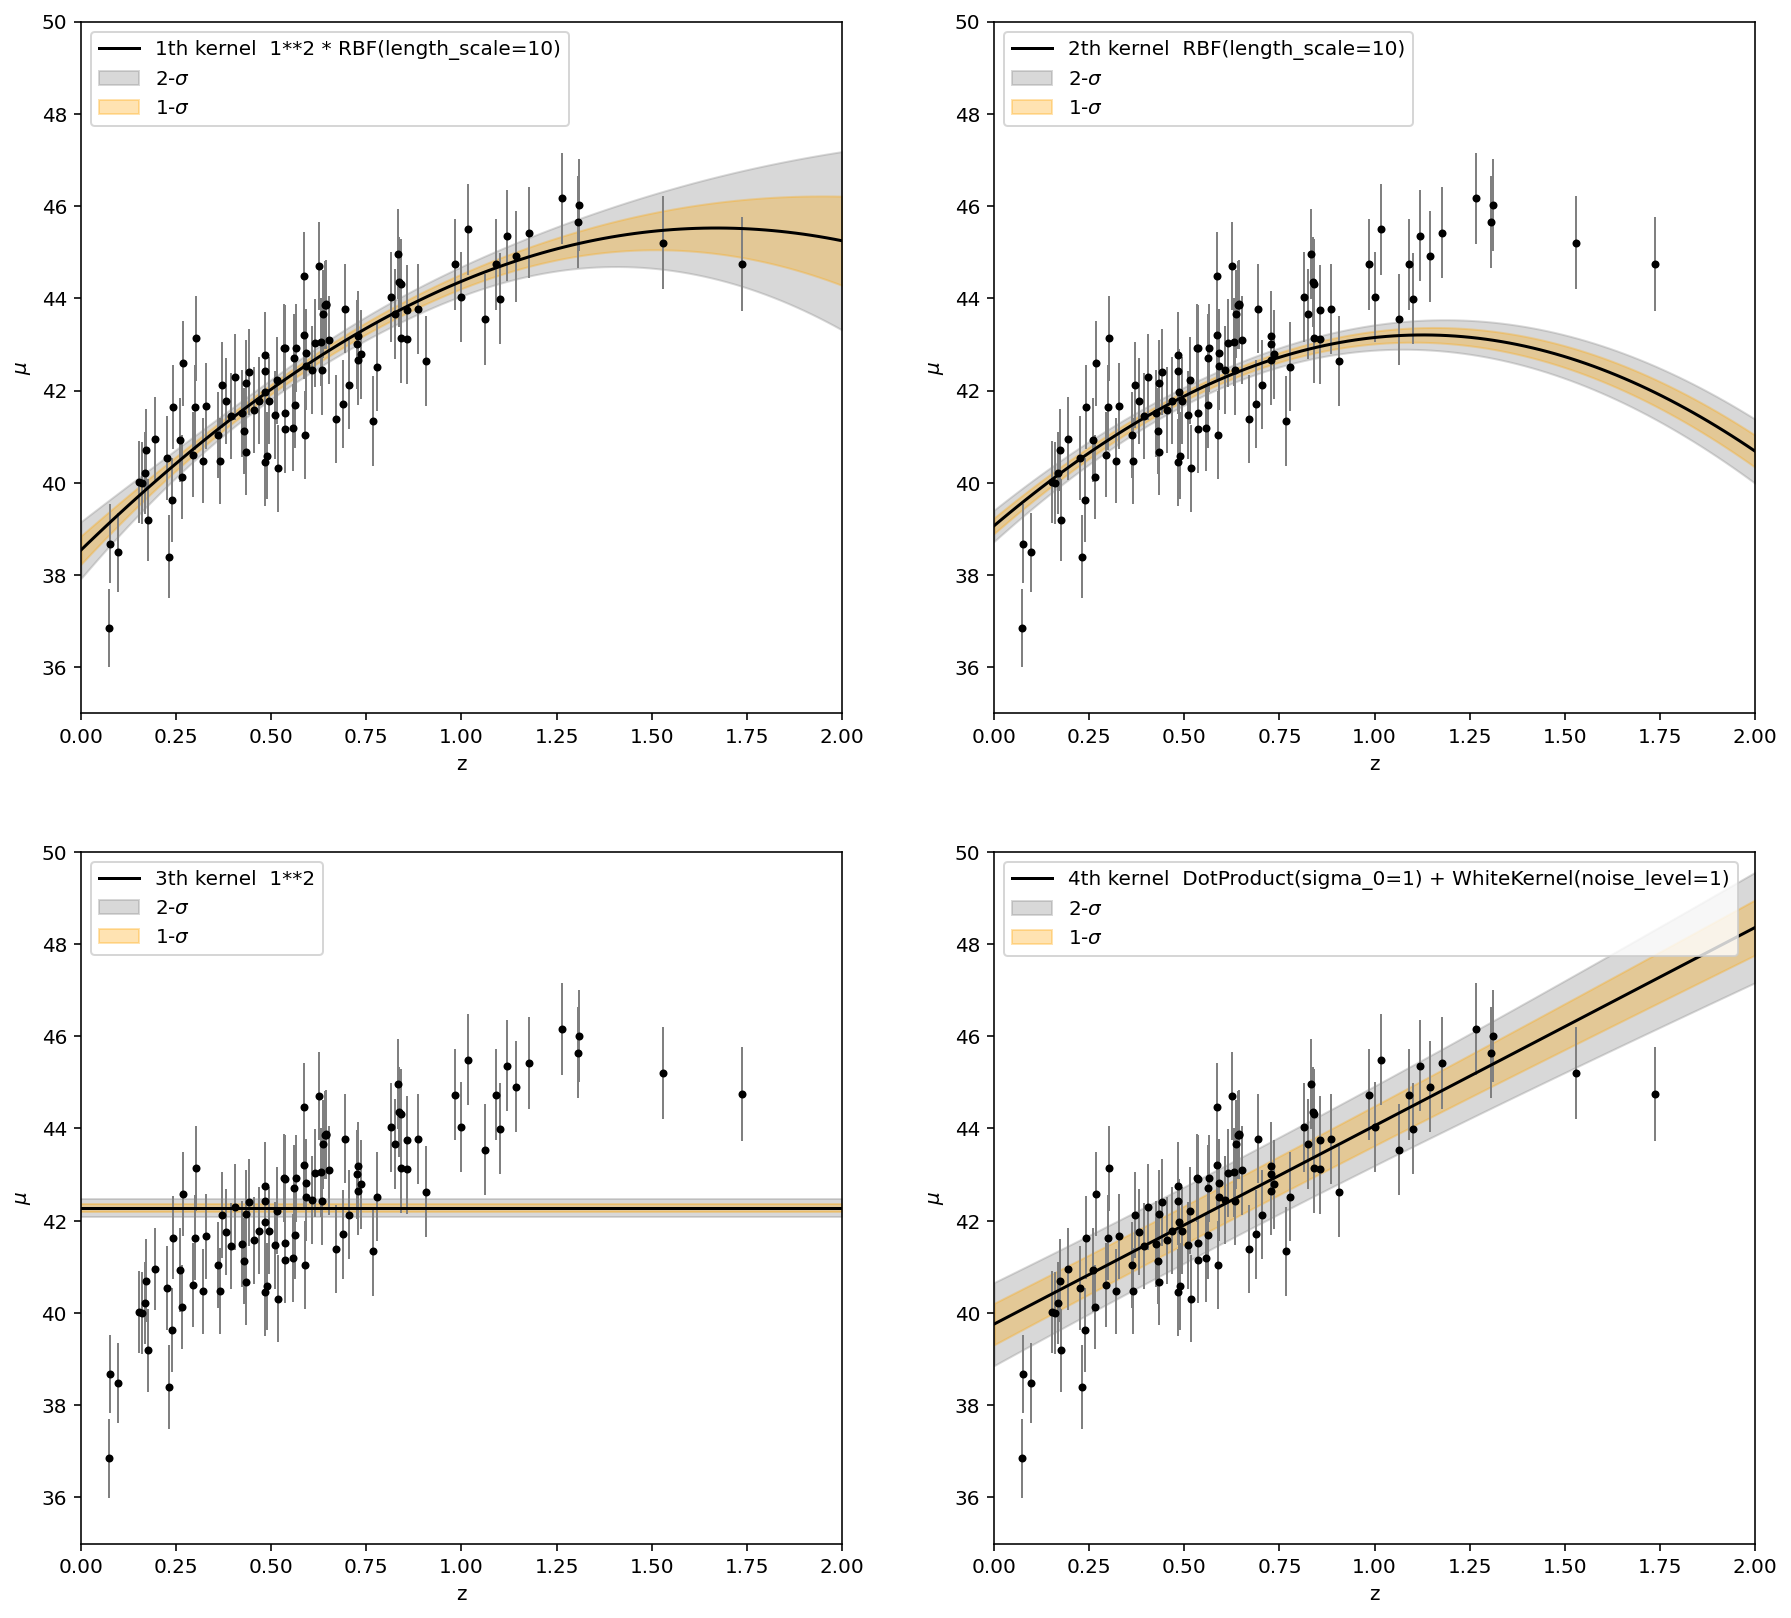

In [4]:
z_test = np.linspace(0, 2, 100)
fig,axs = plt.subplots(int(len(kernel_s)/2), 2, figsize=(15,14))
c_axs = np.concatenate(axs)

for k, ax, i in zip(kernel_s, c_axs, range(0, len(kernel_s))): 
    
    gp = GaussianProcessRegressor(kernel=k,
                               alpha=(dmu) ** 2, 
                               random_state=1)
    
    gp.fit(z_sample.reshape(-1, 1), mu_sample)
    
    y_pred, dy_pred = gp.predict(z_test.reshape(-1, 1), return_std=True)
    
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
    
    ax.plot(z_test, y_pred, label=f"{i+1}th kernel  " + str(k), c='black')
    
    ax.fill_between(z_test, y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, color='gray', alpha=0.3, label='2-$\sigma$')
    ax.fill_between(z_test,  y_pred - dy_pred, y_pred + dy_pred, color='orange', alpha=0.3, label='1-$\sigma$')

    
    ax.set_xlabel("z")
    ax.set_ylabel("$\mu$")
    ax.legend(loc='upper left', fontsize = 'medium')
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)

The kernel I trust the most to explain how my data varies is the first one (also because I saw the solutions). I will however try to cross validate the result: 

## Optimizing the used parameters
I decided to find the optimized parameters by the use of the MLE (marginalized, and of the training data). 

"A gradient-based optimizer is typically used for efficiency. Because the log marginal likelihood is not necessarily convex, multiple restarts of the optimizer with different initializations is used ($\textit{n_restarts_optimizer}$) (source: [towardsdatascience.com](https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319#:~:text=Gaussian%20process%20regression%20(GPR)%20is,uncertainty%20measurements%20on%20the%20predictions.))"

In [5]:
kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(z_sample[:, None], mu_sample)
params = model.get_params()
kernel_params = model.kernel_.get_params()

print("fit params", params)
print("kernel params", kernel_params)

fit params {'alpha': 0.1, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=10), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k2__length_scale': 10, 'kernel__k2__length_scale_bounds': (0.01, 100.0), 'kernel': 1**2 * RBF(length_scale=10), 'n_restarts_optimizer': 10, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
kernel params {'k1': 1.16**2, 'k2': RBF(length_scale=0.0856), 'k1__constant_value': 1.342979363113195, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale': 0.08562630288882946, 'k2__length_scale_bounds': (0.01, 100.0)}


---

# Parameter estimation

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fir it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

# Curve_fit algorithm

In [6]:
def fit(z, Om0, H0): 
    
    if Om0 >0: 
    
        c = FlatLambdaCDM(H0, Om0)
    
        return c.distmod(z).value
    
    return 0

In [7]:
params, cov = curve_fit(fit, dataset_corr_[:, 0], dataset_corr_[:, 1])

In [8]:
print("Om0:", params[0], "+/-", np.sqrt(cov[0, 0]))
print("H0:", params[1], "+/-", np.sqrt(cov[1, 1]))

Om0: 0.2773208697810656 +/- 0.2444401592303391
H0: 70.37104164186249 +/- 7.4820011923283385


To see if these two values are correlated I will look at the covariance matrix.

In [9]:
print(cov)

[[ 0.05975099 -1.67769502]
 [-1.67769502 55.98034184]]


There is some degree of correlation. Let's see to what extent!

---
# Emcee sampling

In [10]:
def Model(par, z): 
    
    Om0, H0 = par
    
    if Om0 >0: 
    
        c = FlatLambdaCDM(H0, Om0)
    
        return c.distmod(z).value
    
    return 0



def log_prior(par):
    
    Om0, H0 = par
    
    if Om0 <0 or H0 > 100 or H0 <50 or Om0 >1: 
        return -np.inf
    
    else:
        return -np.log(50 * 1)


def log_likelihood(par, z, mu, err_mu):
    
    model = Model(par, z)
    
    return - 0.5 * np.sum(np.log(2*np.pi*err_mu**2) + ((mu - model) / err_mu)**2)


def log_posterior (par, z, mu, err_mu):
    
    lp = log_prior(par)
    
    if np.isfinite(lp):
        return lp + log_likelihood(par, z, mu, err_mu)
    
    else:
        return lp

In [11]:
ndim = 2  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses =  np.array([0.2, 70]) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu))
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

100%|█████████████████████████████████████████████████████████| 100000/100000 [19:15<00:00, 86.56it/s]


See the traceplots:

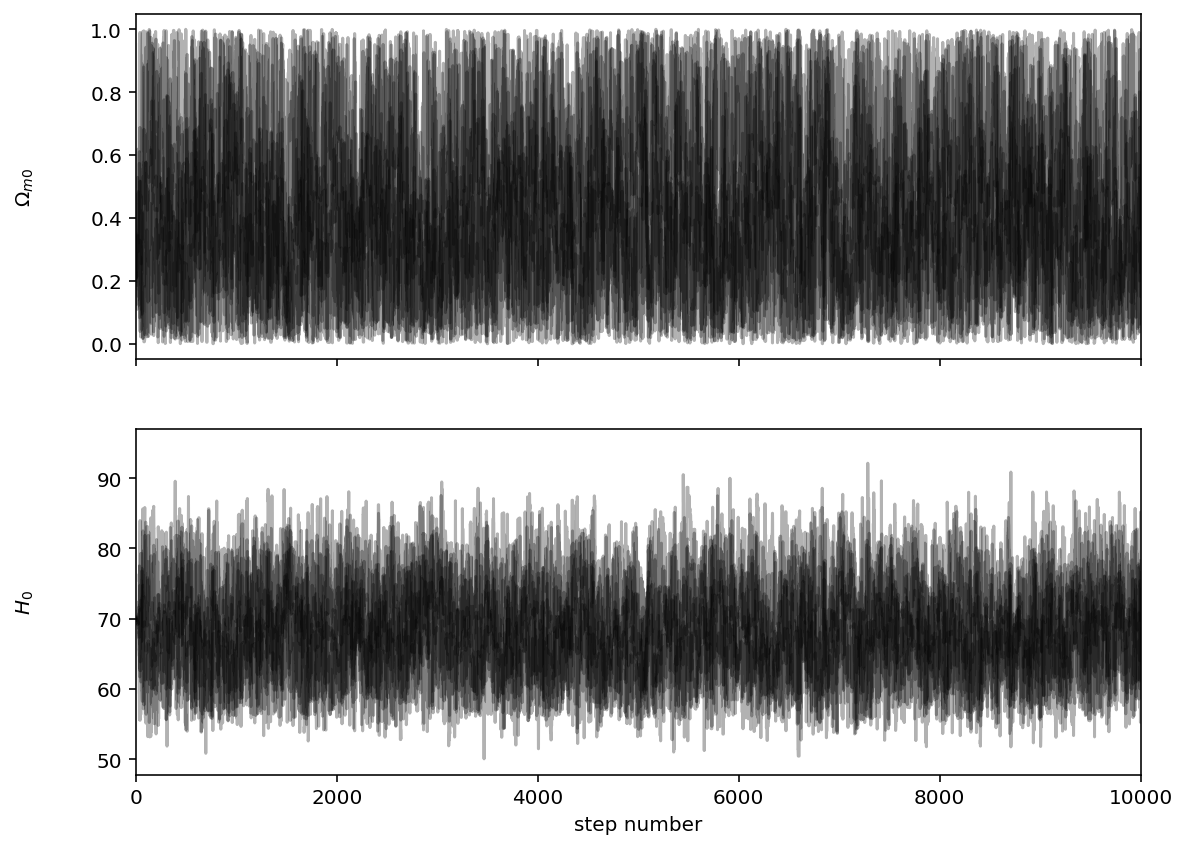

In [12]:
fig, axes = plt.subplots(2, figsize=(9, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"$\Omega_{m0}$", r"$H_0$"]

for i in range(0, ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c="k", alpha=0.3)
    ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Getting the autocorrelation time and selecting burning terms..

In [13]:
tau = sampler.get_autocorr_time()
burn = 100

flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True) 

..to get the posterior distribution!

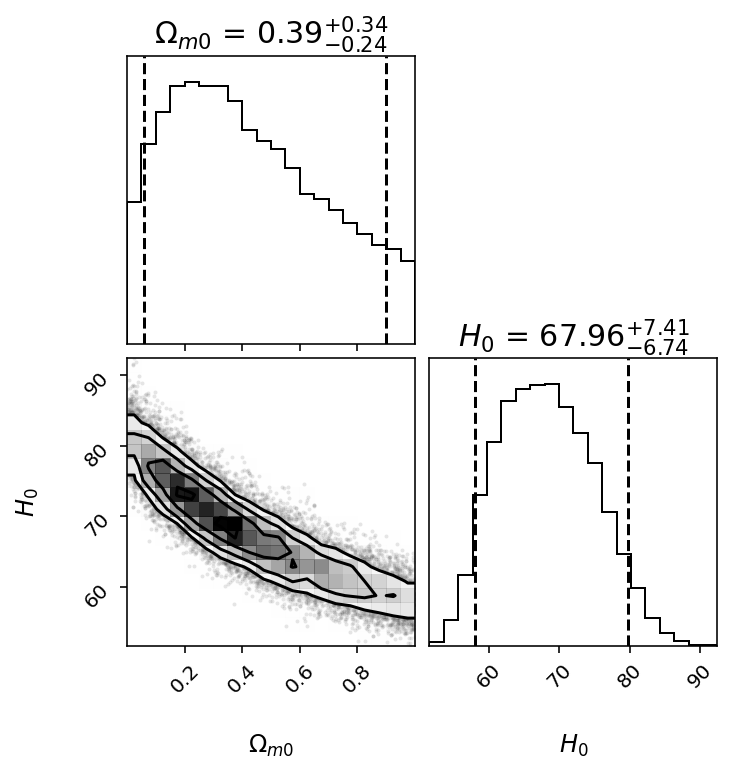

In [14]:
fig = corner.corner(
    flat_samples, labels=[r"$\Omega_{m0}$", r"$H_0$"], quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12)
);

Here I am seeing the posterior spread of model solutions, to better explain the linearity in the parameters plane.

/Users/nicolegrillo/.local/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1341: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


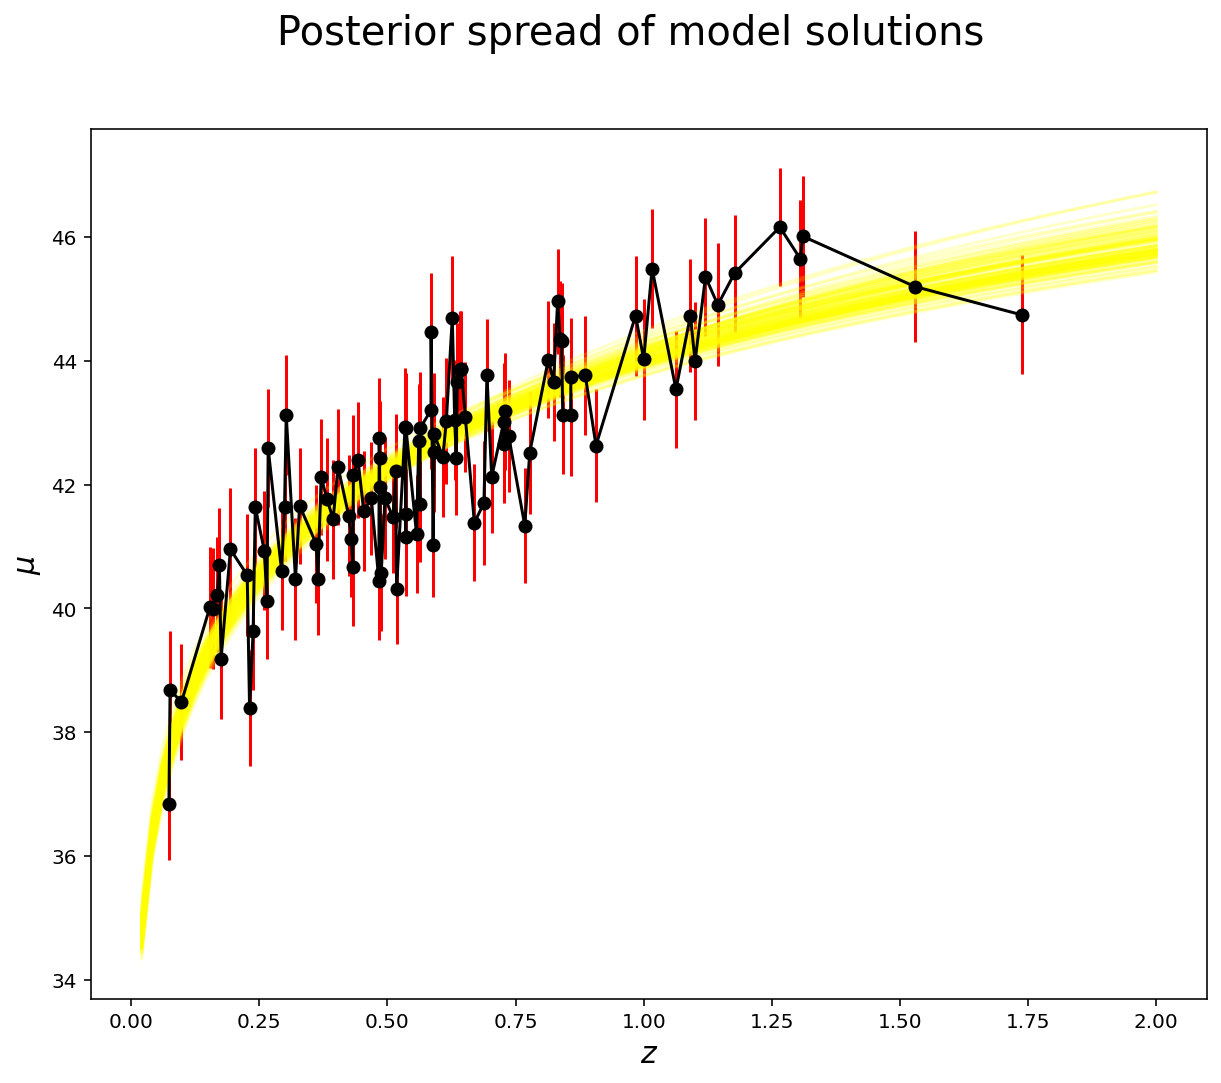

In [15]:
z_plot = np.linspace(0,2,100)

#plot section:

plt.figure(figsize=(10, 8))
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, marker='o', c="k", ecolor='red')
plt.xlabel("$z$", size=15)
plt.ylabel("$\mu$", size=15)
plt.suptitle("Posterior spread of model solutions", size=20);


for i in range(0, 100): 
    
    chosen_post = int(scipy.stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], z_plot)
    
    plt.plot(z_plot, my_Model, alpha=0.2, c='yellow')

### PCA attempt

In the corner plots I produced I can see that there is a preferred direction of data. My idea is to try to see whether the PCA can help me find a nice and still valid way to analyse the dataset. 

In [16]:
flat_samples.shape

(18160, 2)

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True) # 2 n_components I need
pca.fit(flat_samples) 
print("explained variance ratio:", pca.explained_variance_ratio_)

X_reduced = pca.fit_transform(flat_samples)

explained variance ratio: [9.99660530e-01 3.39470359e-04]


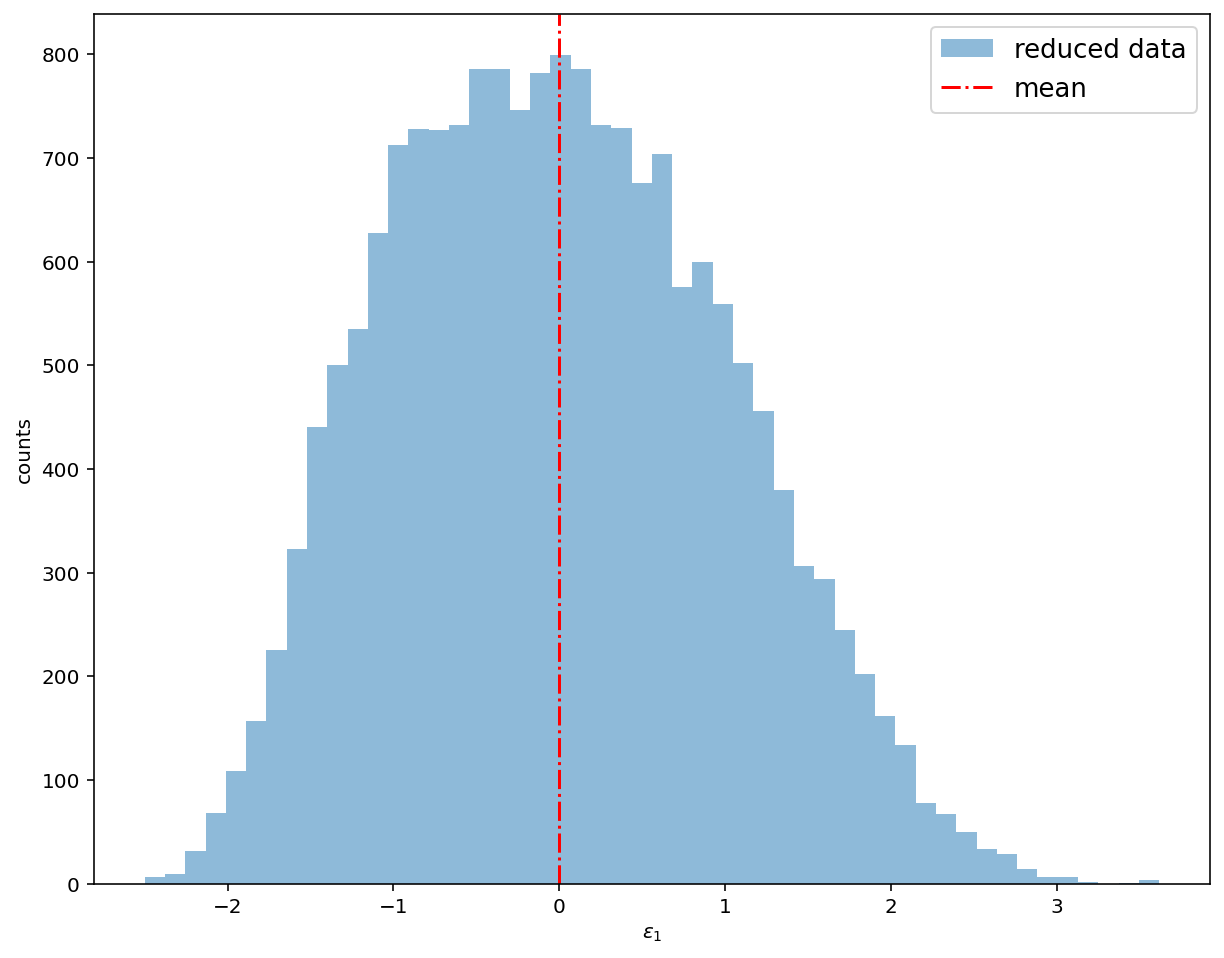

In [32]:
plt.figure(figsize=(10, 8))
plt.hist(X_reduced[:, 0], bins=50, alpha=0.5, label='reduced data')
plt.xlabel(r"$\epsilon_{1}$")
plt.ylabel(r"counts")
plt.axvline(x=np.mean(X_reduced[:, 0]), c='r', linestyle='-.', label='mean')
plt.legend(fontsize=13, loc='upper right');

In [35]:
print(np.mean(X_reduced[:, 0]))

-1.966513100181863e-15


### Reconstruction
$PCA_{R} = \mathrm{PC_{scores}} \cdot \mathrm{E}^{T} + \mu$

In [27]:
print(pca.components_)  # eigenvectors
print(pca.explained_variance_)  # eigenvalues^2

[[-0.0339858   0.99942232]
 [ 0.99942232  0.0339858 ]]
[4.45781707e+01 1.51381066e-02]


In [45]:
mu = np.mean(X_reduced[:, 0])
res = pca.inverse_transform(mu)

print(res[0, :]) # get back to the values from the mean

[ 0.42387941 68.28075078]


In [49]:
# data dispersion with emcee results: 

vals_pca = res[0, :]

dist_s = [np.abs(vals_pca[0] - flat_samples[:, 0].mean()), np.abs(vals_pca[1] - flat_samples[:, 1].mean())]

print("abs dev:", dist_s)

abs dev: [2.1094237467877974e-15, 0.0]


PCA is not necessary as it gives basically the same estimate, but at a large computational cost ($\mathcal{O}(N^{3})$).  

---
# Nested sampling

In [50]:
# Define the dimensionality of the problem
ndim = 2

#define the TRANSFORM for the uniform prior (here uniform):

def ptform(theta):
    
    Om0, H0 = theta # unpack the parameters

    return (scipy.stats.uniform.ppf(Om0, 0, 1), scipy.stats.uniform.ppf(H0, 50, 100))

def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((dataset_corr_[:, 1] - Model(theta, dataset_corr_[:, 0])) / dmu)**2)

Run the sampler and evaluate the evidence:

In [51]:
sampler = dynesty.NestedSampler(loglikelihood_dynesty, ptform, ndim)  # , nlive=1000
sampler.run_nested()
sresults = sampler.results

1932it [00:42, 45.80it/s, +500 | bound: 1 | nc: 1 | ncall: 18789 | eff(%): 13.298 | loglstar:   -inf < -133.212 <    inf | logz: -136.219 +/-  0.059 | dlogz:  0.001 >  0.509]


In [52]:
logZdynesty = sresults.logz[-1]        # value of logZ
logZerrdynesty = sresults.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [53]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty, logZerrdynesty))

Marginalised evidence (using static sampler) is -136.218989889859 ± 0.13135001020117673


Visualize the traceplots:

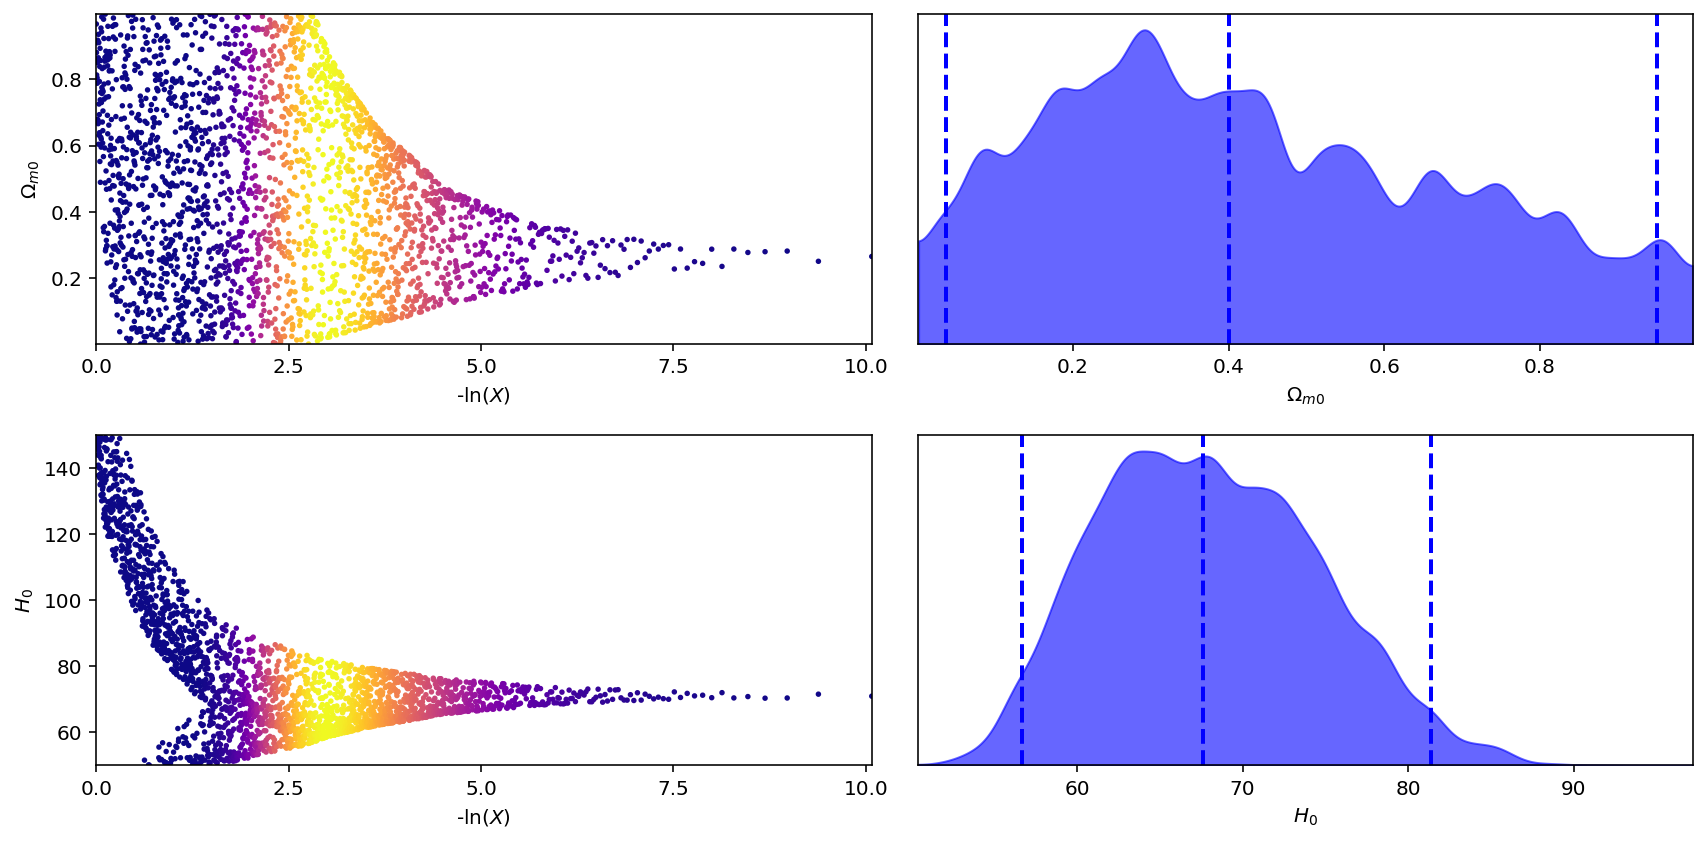

In [54]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(sresults, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$\Omega_{m0}$")
taxes[0][1].set_xlabel("$\Omega_{m0}$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$H_0$")
taxes[1][1].set_xlabel("$H_0$")


tfig.tight_layout()

In [55]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
postsamples = resample_equal(sresults.samples, weights)

Visualize the sampled posterior distribution:

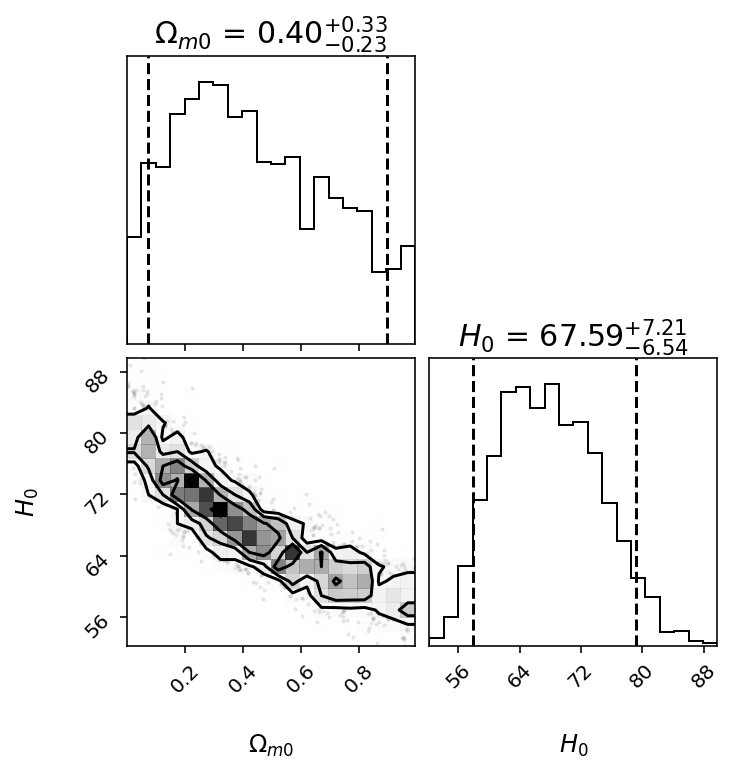

In [56]:
fig = corner.corner(
    postsamples, labels=labels, quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12)
);

---
# Modelling without $\Lambda$

I am doing the same as above, then evaluate the Bayes factor to see if there's a preferred model for data.

In [57]:
def Model_1(par, z): 
    
    H0 = float(par)
    
    c = FlatLambdaCDM(H0=H0, Om0=1)
     
    return c.distmod(z).value

In [58]:
# Define the dimensionality of the problem
ndim = 1

#define the TRANSFORM for the uniform prior (here uniform):

def ptform_1(theta):
    
    H0 = theta # unpack the parameters

    return (scipy.stats.uniform.ppf(H0, 50, 100))

def loglikelihood_dynesty_1(theta):
    """
    The log-likelihood function.
    """
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((dataset_corr_[:, 1] - Model_1(theta, dataset_corr_[:, 0])) / dmu)**2)

In [59]:
sampler_1 = dynesty.NestedSampler(loglikelihood_dynesty_1, ptform_1, ndim, nlive=1000)  # , nlive=1000
sampler_1.run_nested()
sresults_1 = sampler_1.results

3208it [00:39, 80.30it/s, +1000 | bound: 0 | nc: 1 | ncall: 23985 | eff(%): 18.308 | loglstar:   -inf < -134.236 <    inf | logz: -137.056 +/-  0.017 | dlogz:  0.001 >  1.009]


In [60]:
logZdynesty_1 = sresults_1.logz[-1]        # value of logZ
logZerrdynesty_1 = sresults_1.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [61]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty_1, logZerrdynesty_1))

Marginalised evidence (using static sampler) is -137.0563710283812 ± 0.11623835193296145


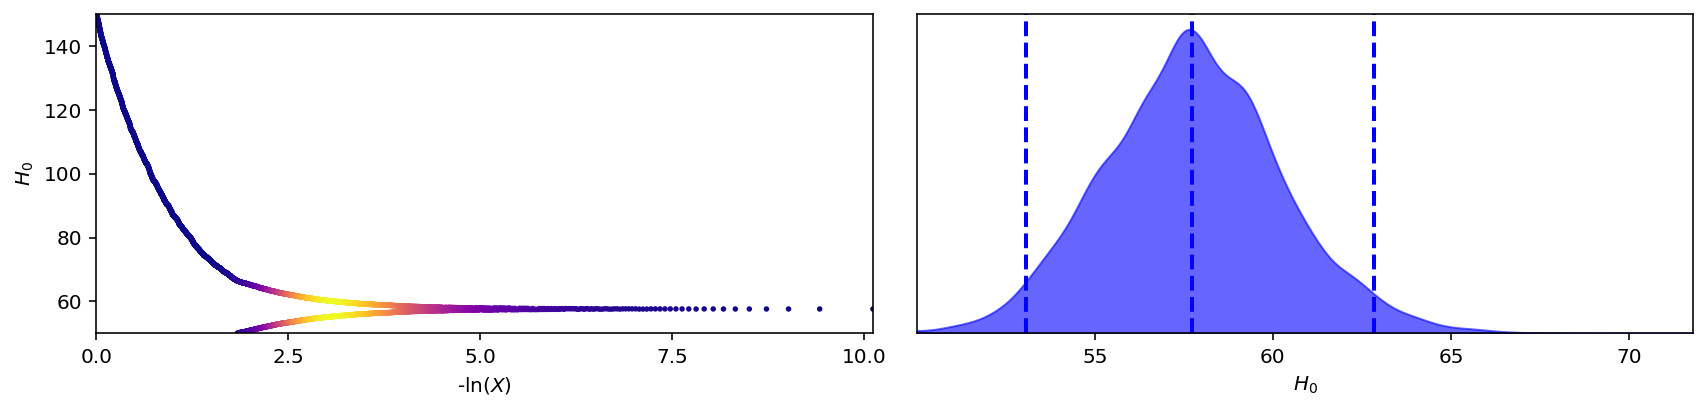

In [62]:
tfig, taxes = dyplot.traceplot(sresults_1, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$H_0$")
taxes[0][1].set_xlabel("$H_0$")


tfig.tight_layout()

In [63]:
B_12 = np.exp(logZdynesty) / np.exp(logZdynesty_1)  # DE model vs not DE model

In [64]:
print("Bayes ratio:", B_12)

Bayes ratio: 2.310308668934224


The fact I obtained $B_{1,2} \sim 2$ indicates that we cannot choose between one model or the other.

---
# Cloning data

I am going to produce some data points from both emcee and GPR:

### Emcee and nested sampling

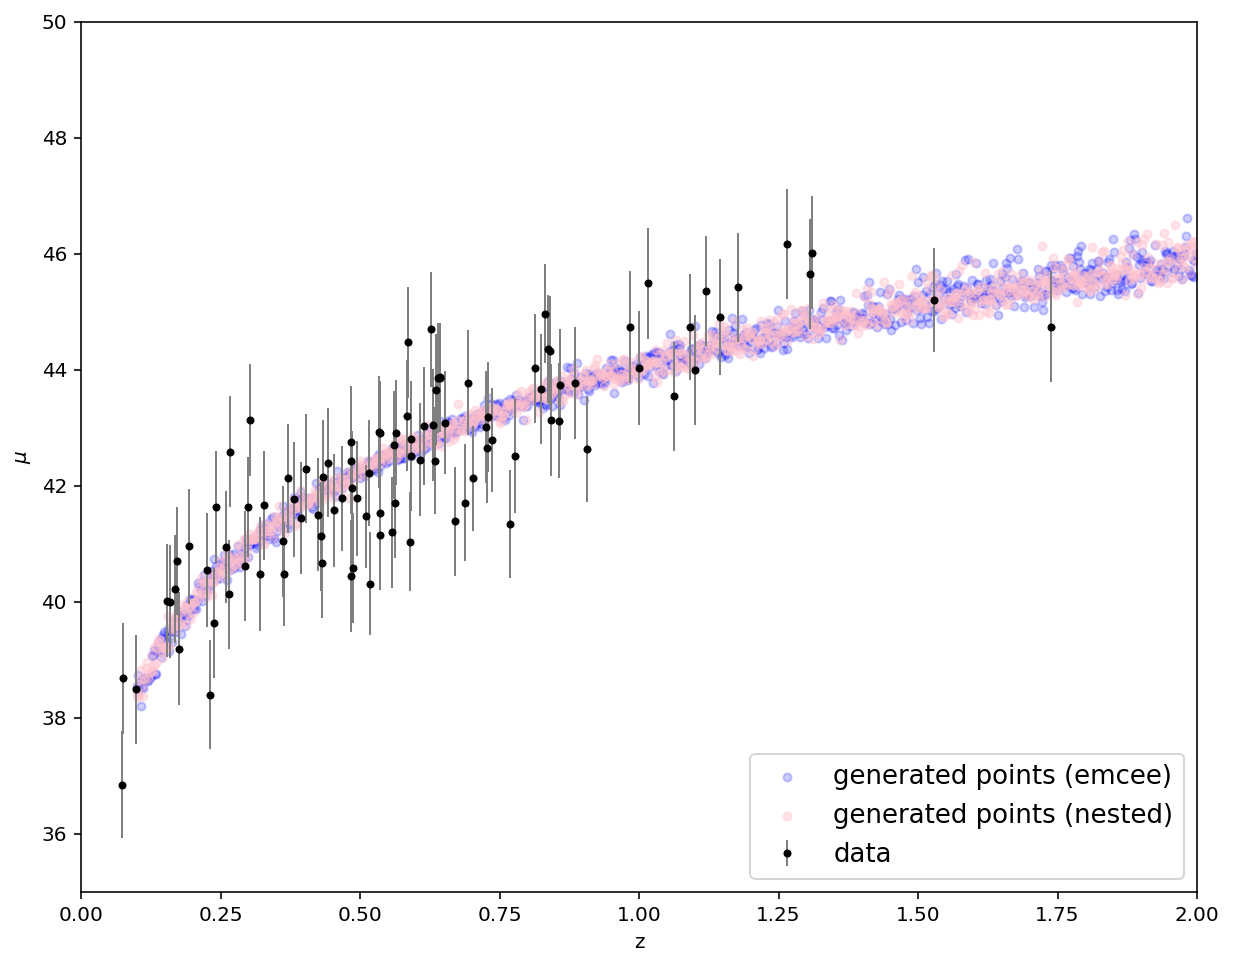

In [65]:
# select random model: 

LCDM_cloned_emcee = []
LCDM_cloned_nested = []
zs_cloning = np.linspace(0.1, 2, 1000)  # uniform z distribution

for i in range(0, 1000):

    chosen_post_emcee = int(scipy.stats.uniform.rvs(0, len(flat_samples)))
    chosen_post_nested = int(scipy.stats.uniform.rvs(0, len(postsamples)))
    
    LCDM_cloned_emcee.append(Model(flat_samples[chosen_post_emcee], zs_cloning[i]))
    LCDM_cloned_nested.append(Model(postsamples[chosen_post_nested], zs_cloning[i]))
    

plt.figure(figsize=(10, 8))
plt.scatter(zs_cloning, LCDM_cloned_emcee, s=16.5, c='blue', alpha=0.2, label='generated points (emcee)') 
plt.scatter(zs_cloning, LCDM_cloned_nested, s=16.5, c='pink', alpha=0.4, label='generated points (nested)') 
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=13)
plt.xlim(0,2)
plt.ylim(35,50);

### GPR:

To extract new points I am going to use the mean function returned by the fit, from where I will add some "degree" of variance based on the posterior spread around it. It means I am extracting ponts from $\hat{f} + \epsilon_{\sigma}$, where $\epsilon_{\sigma}$ comes from a Gaussian centered in $\hat{f}$: 

In [66]:
zs_cloning = np.linspace(0.1, 2, 1000)  # uniform z distribution

k = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=k, alpha=(dmu) ** 2, random_state=1)
    
gpr.fit(z_sample.reshape(-1, 1), mu_sample)  # fit with all the elements I have
    
y_pred, dy_pred = gpr.predict(zs_cloning.reshape(-1, 1), return_std=True)

y_extract = norm.rvs(loc=y_pred, scale=dy_pred)  # generate the numbers within the model (with model as mu and error as sigma)

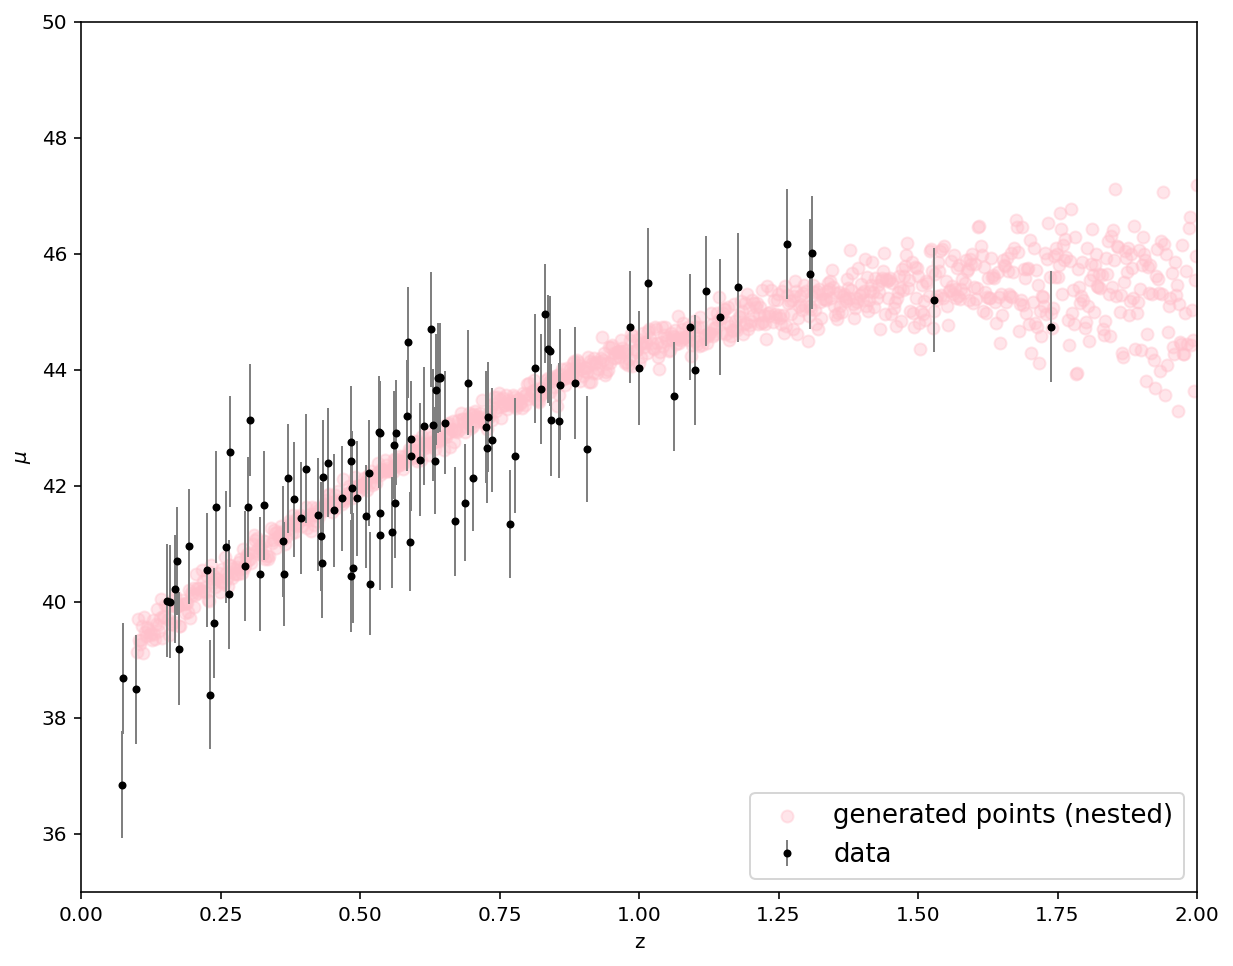

In [67]:
plt.figure(figsize=(10, 8))
plt.scatter(zs_cloning, y_extract, color='pink', alpha=0.4,label='generated points (nested)') 
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=13)
plt.xlim(0,2)
plt.ylim(35,50);